In [21]:
import numpy as np
from sklearn.datasets import load_svmlight_file
import urllib.request
import random
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import SGD, Adam

torch.set_default_dtype(torch.float64)

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [24]:
# np.inf*0

# a = torch.tensor(np.inf)
# b = torch.tensor(0.)
# c = torch.tensor(1e-155)

# a,b,a*b, c ,1/(c**2), c.dtype

In [25]:
# np.random.seed(0)
# n = 10000
# d = 119
# A = np.random.randn(n,d)
# xopt = np.random.randn(d)
# b=np.dot(A,xopt)

# xopt = torch.Tensor(xopt)

In [26]:
# len(b)

In [27]:
# b

In [28]:
# for i in range(len(b)):
#     if b[i]>0:
#         b[i]=1
#     else:
#         b[i]=-1

In [29]:
# b

In [30]:
# tA = torch.Tensor(A)
# tb = torch.Tensor(b)


In [31]:
def NLLSQ(w,X,y):
    return torch.mean(torch.square(y-1/(1+torch.exp(-X@w))))

In [32]:
def logreg(w, X, y):
    return torch.mean(torch.log(1 + torch.exp(-y * (X @ w))))

def grad_logreg(w, X, y):
    r = torch.exp(-y * (X @ w))
    return ( (r/(1 + r)) @ (X * -y[:, None]) ) / X.shape[0]

def hess_logreg(w, X, y):
    r = torch.exp(-y * (X @ w))
    return ( X.T @ (  (r/torch.square(1 + r)).reshape(-1, 1) * X ) ) / X.shape[0]

In [49]:
torch.manual_seed(0)
np.random.seed(0)

dataset_name = "mushrooms"
batch_size = 64
dataset_url = f"https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/{dataset_name}"
dataset_src = urllib.request.urlopen(dataset_url)
trainX, trainY = load_svmlight_file(dataset_src)



train_data = torch.tensor(trainX.toarray())
train_target = torch.tensor(trainY)

train_load = TensorDataset(train_data, train_target)
train_dataloader = DataLoader(train_load, batch_size=batch_size, shuffle=False)


scale = 7
r1 = -scale
r2 = scale
scaling_vec = (r1 - r2) * torch.rand(train_data.shape[1]) + r2
scaling_vec = torch.pow(torch.e, scaling_vec)
train_data_scaled = scaling_vec * train_data

train_load_scaled = TensorDataset(train_data_scaled, train_target)
train_dataloader_scaled = DataLoader(train_load_scaled, batch_size=batch_size, shuffle=False)

def fun(At,x,bt):
    return 1/2*torch.mean(torch.norm(At@x-bt)**2)

def dfun(At,x,bt):
    return At.T@(At@x-bt)
    
# def hessfun(At,x,bt):    
#     H=1/n*At.T@At

loss_function = logreg
loss_grad = grad_logreg
loss_hessian = hess_logreg



if loss_function == logreg:
    train_target[train_target == train_target.unique()[0]] = torch.tensor(-1.0, dtype=torch.get_default_dtype())
    train_target[train_target == train_target.unique()[1]] = torch.tensor(1.0, dtype=torch.get_default_dtype())
    assert torch.equal(train_target.unique(), torch.tensor([-1.0, 1.0]))


In [34]:
def rademacher_old(weights):
    return torch.round(torch.rand_like(weights)) * 2 - 1

def diag_estimate_old(weights, grad, iters):
    Ds = []
    for j in range(iters):
        z = rademacher_old(weights)
        with torch.no_grad():
            hvp = torch.autograd.grad(grad, weights, grad_outputs=z, retain_graph=True)[0]
        Ds.append((hvp*z))

    return torch.mean(torch.stack(Ds), 0)

def ttv(tuple_in):
    return torch.cat([t.view(-1) for t in tuple_in])

def flat_hessian(flat_grads,params):
    full_hessian = []
    for i in range(flat_grads.size()[0]):
        temp_hess = torch.autograd.grad(flat_grads[i], params, retain_graph=True)
        full_hessian.append(ttv(temp_hess))
    return torch.stack(full_hessian)

def run_psps2(train_data, train_target, train_dataloader, epochs, precond_method="cg", **kwargs):

    torch.manual_seed(0)
    np.random.seed(0)
    # parameters
    w = torch.zeros(train_data.shape[1], device=device).requires_grad_()

    # save loss and grad size to history
    hist = []

    optimizer = torch.optim.SGD([w],lr=1)
    loss = loss_function(w, train_data.to(device), train_target.to(device))

    # print("loss",loss)

    g, = torch.autograd.grad(loss, w, create_graph=True)
    hessian = flat_hessian(g,[w])
    f_grad = g.clone().detach()


    # print("grad",torch.norm(g).item())

    if precond_method == "none":
        D = torch.ones_like(w)
    elif precond_method == "hutch":
        alpha=0.1
        beta=0.999
        init_iters = kwargs["hutch_init_iters"]
        Dk = diag_estimate_old(w, g, init_iters)
    elif precond_method == "cg" or precond_method == "pcg":
        s = torch.zeros_like(w) # s = H_inv * grad
        r = f_grad - torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]
        p = r.detach().clone()
        r_prev = torch.dot(r, r)
        MAX_ITER = train_data.shape[1] * 2
        # MAX_ITER = 1000

    elif precond_method == "scaling_vec":
        scaling_vec = kwargs["scaling_vec"]
        D = (1 / scaling_vec)**2
    elif precond_method == "adam" or precond_method == "adam_m":
        D = torch.zeros_like(g)
        v = torch.zeros_like(g)
        step_t = torch.tensor(0.)
        betas = (0.9, 0.999)
    elif precond_method == "adagrad" or precond_method == "adagrad_m":
        D = torch.zeros_like(g)
        v = torch.zeros_like(g)

    pcg_method = kwargs.get("pcg_method")
    if pcg_method == "hutch":
        alpha=0.1
        beta=0.999
        init_iters = kwargs["hutch_init_iters"]
        Dk_pcg = diag_estimate_old(w, g, init_iters)
    elif pcg_method == "adam":
        D_pcg = torch.zeros_like(g)
        v_pcg = torch.zeros_like(g)
        step_t_pcg = torch.tensor(0.)
        betas = (0.9, 0.999)
    elif pcg_method == "adagrad":
        D_pcg = torch.zeros_like(g)
        v_pcg = torch.zeros_like(g)
        # v_pcg = torch.diag(hessian)
    elif pcg_method == None:
        D_pcg = torch.ones_like(g)

    cg_steps = []

    for epoch in range(epochs):

        loss = loss_function(w, train_data.to(device), train_target.to(device))
        g, = torch.autograd.grad(loss, w, create_graph=True)
        grad_norm_sq = torch.linalg.norm(g) ** 2
        acc = (np.sign(train_data @ w.detach().numpy()) == train_target).sum() / train_target.shape[0]

        print(f"[{epoch}/{epochs}] | Loss: {loss.item()} | GradNorm^2: {grad_norm_sq.item()} | Accuracy: {acc}")
        hist.append([loss.item(), grad_norm_sq.item(), acc])

        for i, (batch_data, batch_target) in enumerate(train_dataloader):

            loss = loss_function(w, batch_data, batch_target)
            g, = torch.autograd.grad(loss, w, create_graph=True)
            f_grad = g.detach().clone()
            # step_size=1.0


            if precond_method == "hess_diag":
                #hess = loss_hessian(w, batch_data, batch_target)
                hess_diag_inv = 1 / torch.diag(hessian)
                s = hess_diag_inv * f_grad

            elif precond_method == "scaling_vec":
                s = D * f_grad

            elif precond_method == "adam" or precond_method == "adam_m":
                step_t += 1
                v = betas[1] * v + (1 - betas[1]) * g.square()
                v_hat = v / (1 - torch.pow(betas[1], step_t))

                if precond_method == "adam":
                    D = 1 / (torch.sqrt(v_hat) + 1e-6)
                elif precond_method == "adam_m":
                    D = 1 / (v_hat ) # NO SQRT ADAM
                s = D * f_grad

            elif precond_method == "adagrad" or precond_method == "adagrad_m":
                v.add_(torch.square(g))
                if precond_method == "adagrad":
                    D = 1 / (torch.sqrt(v) + 1e-6)
                elif precond_method == "adagrad_m":
                    D = 1 / (v ) # NO SQRT ADAGRAD
                s = D * f_grad

            elif precond_method == "none":
                s = D * f_grad

            elif precond_method == "hutch":
                vk = diag_estimate_old(w, g, 1)

                # Smoothing and Truncation
                Dk = beta * Dk + (1 - beta) * vk
                Dk_hat = torch.abs(Dk)
                Dk_hat[Dk_hat < alpha] = alpha

                D = 1 / Dk_hat
                s = D * f_grad


            elif precond_method == "pcg":
                
                if pcg_method == "hess_diag":
                #hess = loss_hessian(w, batch_data, batch_target)
                    D_pcg = 1 / torch.diag(hessian)  
                elif pcg_method == "hutch":
                    vk_pcg = diag_estimate_old(w, g, 1)
                    # Smoothing and Truncation
                    Dk_pcg = beta * Dk_pcg + (1 - beta) * vk_pcg
                    Dk_hat = torch.abs(Dk_pcg)
                    Dk_hat[Dk_hat < alpha] = alpha
                    D_pcg = 1 / Dk_hat
                elif pcg_method == "adam":
                    step_t_pcg += 1
                    v_pcg = betas[1] * v_pcg + (1 - betas[1]) * f_grad.square()
                    v_hat = v_pcg / (1 - torch.pow(betas[1], step_t_pcg))
                    D_pcg = 1 / v_hat
                    #D_pcg = 1 / (torch.sqrt(v_hat) + 1e-8)
                elif pcg_method == "adagrad":
                    v_pcg.add_(f_grad.square())
                    #print(v_pcg)
                    # D_pcg = 1/v_pcg
                    # print(torch.norm(v_pcg),"v_pcg")
                    D_pcg = v_pcg
                    eps = 1e-3

                    D_pcg[torch.abs(v_pcg) > eps] = 1 / (v_pcg[torch.abs(v_pcg) > eps])# + 1e-8)

                    # print(torch.norm(D_pcg),"D_pcg")


                    #print(D_pcg)
                elif pcg_method == "none":
                    D_pcg = torch.ones_like(f_grad)

                #hess = loss_hessian(w, batch_data, batch_target)
                
        
                #hess_diag_inv = 1 / torch.diag(hess)

                hess_diag_inv = D_pcg.clone()


                # hess_diag_inv *= 0
                # hess_diag_inv +=1

                # hess_diag=1/hess_diag_inv
                gamma=0.7
            

                # Preconditioned CG is here
                s = torch.zeros_like(w) # s = H_inv * grad
                x = torch.zeros_like(w)
                r = f_grad.clone()
                z = hess_diag_inv * r
                p = z.clone()
                # step_size = 1.0

                for cg_step in range(MAX_ITER):
                    hvp = torch.autograd.grad(g, w, grad_outputs=p, retain_graph=True)[0]
                
                    if torch.dot(p,hvp)<=0:
                        # if cg_step==0:
                            
                        # print("NEGATIVE CURVATURE")
                        s=gamma*x  +(1-gamma)*p*torch.sign(torch.dot(p,f_grad))
                        hvs = torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]
                        # print("step_size=",torch.dot(s,hvs))
                        # print(torch.max(torch.tensor([loss/torch.dot(s,hvs),0])))
                        # step_size=torch.min(torch.max(torch.tensor([loss/torch.dot(s,hvs),0])),torch.tensor(20))
                        step_size=torch.min(torch.tensor([torch.abs(loss/torch.dot(s,hvs)),5]))
                        #step_size=1.0
                        # print(step_size)
                        # print("Nega:stepsize",step_size)
                        # print(f"PCG Took {cg_step}")
                        break
                    alpha_k = torch.dot(r, z) / torch.dot(p, hvp)
                    # print("alpha",alpha_k)
                    x = x + alpha_k * p
                    # print("x",x*scaling)
                    r_prev = r.clone()
                    r = r - alpha_k * hvp
                    # print(torch.dot(r,hess_diag_inv*r))
                    # if torch.norm(r)<1e-4:
                    # print(torch.dot(r,hess_diag_inv*r),'sssss')
                    if torch.dot(r,hess_diag_inv*r) < 1e-5:
                        s=x
                        # print("hit stopping")
                        # print(f"PCG Took {cg_step}")
                        # Ax = torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]
                        # diff = torch.norm(Ax - f_grad)
                        # print(f"PCG Took {cg_step} to reach diff={diff}")
                        # cg_steps.append(cg_step)
                        grad_norm_sq_scaled = torch.dot(f_grad, s)
                        if 2 * loss <= grad_norm_sq_scaled:
                            c = loss / ( grad_norm_sq_scaled )
                            det = 1 - 2 * c
                            if det < 0.0:
                                step_size = 1.0 
                            else:
                                # print("**")
                                step_size = 1 - torch.sqrt(det)
                        else:
                            # print(f"[{epoch}, {i}] No solution")
                            # print("***")
                            step_size = 1.0
                        # print("sp:stepsize",step_size)
                        
                        break

                    z_prev = z.clone()
                    z = hess_diag_inv * r
                    beta_k = torch.dot(r, z) / torch.dot(r_prev, z_prev)
                    p = z + beta_k * p
                    # step_size=1.0

            # if i % 1 == 0:
            #     loss = loss_function(w, train_data.to(device), train_target.to(device))
            #     g, = torch.autograd.grad(loss, w, create_graph=True)
            #     grad_norm_sq = torch.linalg.norm(g) ** 2
            #     print(f"[{epoch}][{i}] |stepsize:{step_size}| Loss: {loss.item()} | GradNorm^2: {grad_norm_sq.item()} | Accuracy: {acc}")
            #     hist.append([loss.item(), grad_norm_sq.item(), acc])


            # step_size = 1.0
            # print(step_size)
            # FB =  loss_function(w, train_data.to(device), train_target.to(device))
            # FBB =  loss_function(w, batch_data, batch_target)
            with torch.no_grad():
                w.sub_(step_size *s)
            # FA =  loss_function(w, train_data.to(device), train_target.to(device))
            # FAA =  loss_function(w, batch_data, batch_target)

            # print(FA - FB, " <<< 0", FAA - FBB)


    return hist

# hist_pcg = run_psps2(train_data, train_target, train_dataloader, EPOCHS, precond_method="pcg",pcg_method="adagrad")

In [35]:
EPOCHS = 50

In [36]:
hist_cg = run_psps2(train_data, train_target, train_dataloader, EPOCHS, precond_method="pcg",pcg_method="hess_diag")

[0/50] | Loss: 0.6931471805599453 | GradNorm^2: 0.31956696075430274 | Accuracy: 0.0
[1/50] | Loss: 0.039441469882174604 | GradNorm^2: 0.0009720275058191371 | Accuracy: 0.9842442146725751
[2/50] | Loss: 0.0014534886161833025 | GradNorm^2: 3.427716446455091e-06 | Accuracy: 0.9996307237813885
[3/50] | Loss: 0.0003814690980655098 | GradNorm^2: 1.1559430144304067e-06 | Accuracy: 0.9997538158542589
[4/50] | Loss: 0.00033147328701074556 | GradNorm^2: 9.918493050981936e-07 | Accuracy: 0.9997538158542589
[5/50] | Loss: 0.00038208754435541955 | GradNorm^2: 1.1073559914387316e-06 | Accuracy: 0.9997538158542589
[6/50] | Loss: 0.0003190657268373392 | GradNorm^2: 8.390303045209769e-07 | Accuracy: 0.9997538158542589
[7/50] | Loss: 0.0002557076661119266 | GradNorm^2: 6.100245045145116e-07 | Accuracy: 0.9997538158542589
[8/50] | Loss: 0.00016790060318677807 | GradNorm^2: 3.2319720053674973e-07 | Accuracy: 0.9998769079271295
[9/50] | Loss: 8.051690272435012e-05 | GradNorm^2: 9.6585980085882e-08 | Accura

In [37]:
hist_pcg_scaled = run_psps2(train_data_scaled, train_target, train_dataloader_scaled, EPOCHS, precond_method="pcg",pcg_method="hess_diag")

[0/50] | Loss: 0.6931471805599453 | GradNorm^2: 20858.902363831996 | Accuracy: 0.0
[1/50] | Loss: 0.03944148982545664 | GradNorm^2: 8.478232640217952 | Accuracy: 0.9842442146725751
[2/50] | Loss: 0.0014534822241855816 | GradNorm^2: 0.048771299817826685 | Accuracy: 0.9996307237813885
[3/50] | Loss: 0.00038146830433040364 | GradNorm^2: 0.018714227091277076 | Accuracy: 0.9997538158542589
[4/50] | Loss: 0.0003314738425418557 | GradNorm^2: 0.015356906170798053 | Accuracy: 0.9997538158542589
[5/50] | Loss: 0.0003820861665551057 | GradNorm^2: 0.018685000982293542 | Accuracy: 0.9997538158542589
[6/50] | Loss: 0.00031905512714400155 | GradNorm^2: 0.015167413338492742 | Accuracy: 0.9997538158542589
[7/50] | Loss: 0.00025570973742071186 | GradNorm^2: 0.011238476199898432 | Accuracy: 0.9997538158542589
[8/50] | Loss: 0.0001678972016532032 | GradNorm^2: 0.005953372218773102 | Accuracy: 0.9998769079271295
[9/50] | Loss: 8.051609091958424e-05 | GradNorm^2: 0.001777775224080315 | Accuracy: 1.0
[10/50]

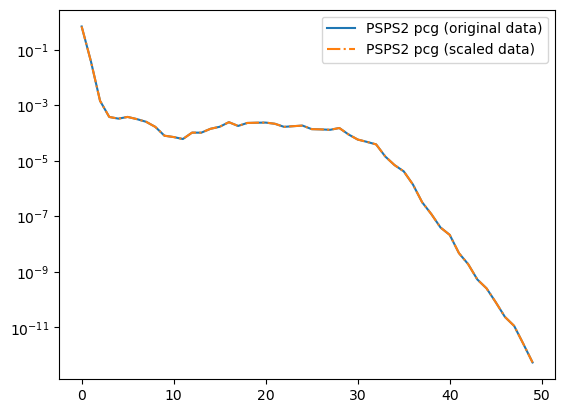

In [38]:
plt.semilogy([x[0] for x in hist_cg], label="PSPS2 pcg (original data)")
# plt.semilogy([x[0] for x in hist_pcg], linestyle="--", label="PSPS2 pcg (original data)")
plt.semilogy([x[0] for x in hist_pcg_scaled], linestyle="-.", label="PSPS2 pcg (scaled data)")

plt.legend()